In [34]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

### Model parameters

In [33]:

# input image size = 112,112 
# batch size = 16 
# input filters = 8 
# epoch size = 20 

### Checking the GPU availability 

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


### Data directory

In [3]:
data_dir = r'C:\Users\91937\Downloads\HTAProject\Split_dataset2'
print(os.listdir(data_dir))
classes = os.listdir(data_dir+'/train')
print(classes)

['test', 'train', 'val']
['Acinetobacter.baumanii', 'Actinomyces.israeli', 'Bacteroides.fragilis', 'Bifidobacterium.spp', 'Candida.albicans', 'Clostridium.perfringens', 'Enterococcus.faecalis', 'Enterococcus.faecium', 'Escherichia.coli', 'Fusobacterium', 'Lactobacillus.casei', 'Lactobacillus.crispatus', 'Lactobacillus.delbrueckii', 'Lactobacillus.gasseri', 'Lactobacillus.jehnsenii', 'Lactobacillus.johnsonii', 'Lactobacillus.paracasei', 'Lactobacillus.plantarum', 'Lactobacillus.reuteri', 'Lactobacillus.rhamnosus', 'Lactobacillus.salivarius', 'Listeria.monocytogenes', 'Micrococcus.spp', 'Neisseria.gonorrhoeae', 'Porfyromonas.gingivalis', 'Propionibacterium.acnes', 'Proteus', 'Pseudomonas.aeruginosa', 'Staphylococcus.aureus', 'Staphylococcus.epidermidis', 'Staphylococcus.saprophiticus', 'Streptococcus.agalactiae', 'Veionella']


### Sampling

In [4]:
vionella_files = os.listdir(data_dir + "/train/Veionella")
print('No. of training examples for airplanes:', len(vionella_files))
print(vionella_files[:5])

No. of training examples for airplanes: 20
['Veionella_0001.tif', 'Veionella_0002.tif', 'Veionella_0003.tif', 'Veionella_0004.tif', 'Veionella_0005.tif']


### Transformations for increasing the data

In [6]:
transform_train=transforms.Compose([
    transforms.Resize((112,112)),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
])

transform_val=transforms.Compose([
    transforms.Resize((112,112)),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
])

### Use the `ImageFolder` class from `torchvision` to load the data as PyTorch tensors.

In [7]:
original_dataset = ImageFolder((data_dir+'/train'), transform=ToTensor())
train_dataset = ImageFolder((data_dir+'/train'), transform=transform_train)
val_dataset = ImageFolder((data_dir+'/val'), transform=transform_val)

### Image sizes before and afer resizing

In [8]:
img_1,label_1 = original_dataset[0]
img, label = train_dataset[0]
print(img_1.shape,label_1)
print(img.shape, label)

torch.Size([3, 1532, 2048]) 0
torch.Size([3, 112, 112]) 0


### Data Classes

In [9]:
print(train_dataset.classes)

['Acinetobacter.baumanii', 'Actinomyces.israeli', 'Bacteroides.fragilis', 'Bifidobacterium.spp', 'Candida.albicans', 'Clostridium.perfringens', 'Enterococcus.faecalis', 'Enterococcus.faecium', 'Escherichia.coli', 'Fusobacterium', 'Lactobacillus.casei', 'Lactobacillus.crispatus', 'Lactobacillus.delbrueckii', 'Lactobacillus.gasseri', 'Lactobacillus.jehnsenii', 'Lactobacillus.johnsonii', 'Lactobacillus.paracasei', 'Lactobacillus.plantarum', 'Lactobacillus.reuteri', 'Lactobacillus.rhamnosus', 'Lactobacillus.salivarius', 'Listeria.monocytogenes', 'Micrococcus.spp', 'Neisseria.gonorrhoeae', 'Porfyromonas.gingivalis', 'Propionibacterium.acnes', 'Proteus', 'Pseudomonas.aeruginosa', 'Staphylococcus.aureus', 'Staphylococcus.epidermidis', 'Staphylococcus.saprophiticus', 'Streptococcus.agalactiae', 'Veionella']


### Showing example

In [10]:
def show_example(img, label):
    print('Label: ', train_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  Lactobacillus.paracasei (16)


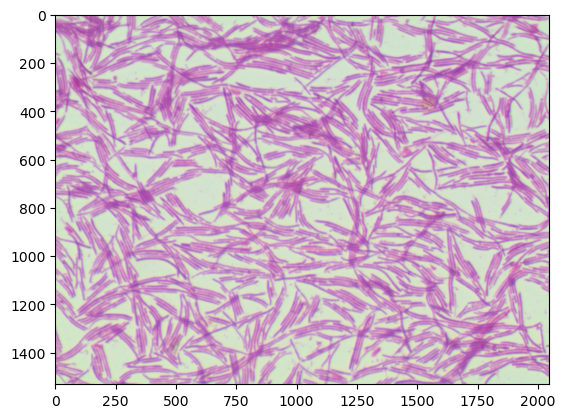

In [11]:
show_example(*original_dataset[300])

Label:  Lactobacillus.paracasei (16)


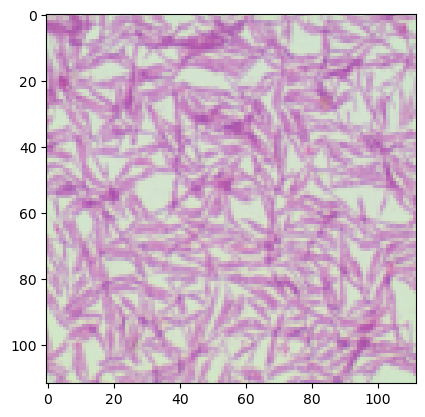

In [12]:
show_example(*train_dataset[300])

### Making the dataloader

In [13]:
batch_size = 16

train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers=4, pin_memory=True)

### View a batch of the images

In [14]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

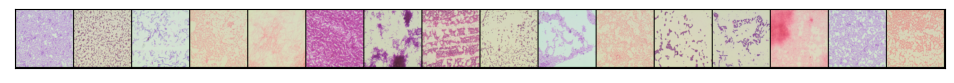

In [80]:
show_batch(train_dl)

### Simple Model

In [15]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

### Input size

In [16]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([16, 3, 112, 112])
out.shape: torch.Size([16, 8, 56, 56])


## Base Class for defining training and validation steps

In [17]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Bacterial colony model

In [18]:
class BacterialColony(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            # input size: 3 * 112 * 112
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            # 8 * 112 * 112
            nn.ReLU(), # does not have any parameters so doesn't change anything
            # 8 * 112 * 112
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            # 16 * 112 * 112
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 16 x 56 x 56 halves the image size 

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 32 x 28 x 28

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 14 x 14

            nn.Flatten(), 
            nn.Dropout(0.25),
            nn.Linear(64*14*14, 1024),
            nn.ELU(),
            nn.Dropout(0.25),
            nn.Linear(1024, 512),
            nn.ELU(),
            nn.Linear(512, 33))
        
    def forward(self, xb):
        return self.network(xb)

## Model Summary

In [19]:
model = BacterialColony()
model

BacterialColony(
  (network): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Dropout(p=0.25, inplace=False)
    (17): Linear(in_features=12544, out_features=1024, bias=True)
    (18)

## Running one batch

In [20]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([16, 3, 112, 112])
out.shape: torch.Size([16, 33])
out[0]: tensor([-0.0001,  0.0122,  0.0520,  0.0187, -0.0163, -0.0268,  0.0075,  0.0271,
        -0.0194, -0.0080,  0.0123, -0.0263,  0.0405,  0.0064,  0.0013,  0.0125,
         0.0270, -0.0363, -0.0103, -0.0172, -0.0281, -0.0359, -0.0201,  0.0080,
        -0.0059,  0.0369,  0.0063, -0.0233,  0.0220, -0.0177, -0.0097, -0.0428,
        -0.0251], grad_fn=<SelectBackward0>)


## GPU helper functions

In [21]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [22]:
device = get_default_device()
device

device(type='cuda')

In [23]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

# Training the Model

In [24]:
with torch.no_grad():
    def evaluate(model, val_loader):
        model.eval()
        outputs = [model.validation_step(batch) for batch in val_loader]
        return model.validation_epoch_end(outputs)

    def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
        history = []
        optimizer = opt_func(model.parameters(), lr)
        for epoch in range(epochs):
            # Training Phase 
            model.train()
            train_losses = []
            for batch in train_loader:
                loss = model.training_step(batch)
                train_losses.append(loss)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            # Validation phase
            result = evaluate(model, val_loader)
            result['train_loss'] = torch.stack(train_losses).mean().item()
            model.epoch_end(epoch, result)
            history.append(result)
        return history


In [25]:
model = to_device(BacterialColony(), device)

In [26]:
evaluate(model, val_dl)

{'val_loss': 3.495940685272217, 'val_acc': 0.03703703731298447}

In [28]:
import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()  

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% | 32% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  0% |  2% |


In [27]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001

In [28]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 3.5108, val_loss: 3.4961, val_acc: 0.0268
Epoch [1], train_loss: 3.5031, val_loss: 3.4973, val_acc: 0.0268
Epoch [2], train_loss: 3.5029, val_loss: 3.4989, val_acc: 0.0370
Epoch [3], train_loss: 3.5005, val_loss: 3.4976, val_acc: 0.0268
Epoch [4], train_loss: 3.5013, val_loss: 3.4983, val_acc: 0.0370
Epoch [5], train_loss: 3.4999, val_loss: 3.4988, val_acc: 0.0268
Epoch [6], train_loss: 3.5001, val_loss: 3.4990, val_acc: 0.0268
Epoch [7], train_loss: 3.5006, val_loss: 3.4987, val_acc: 0.0370
Epoch [8], train_loss: 3.5003, val_loss: 3.4995, val_acc: 0.0223
Epoch [9], train_loss: 3.4987, val_loss: 3.4990, val_acc: 0.0268
Epoch [10], train_loss: 3.5001, val_loss: 3.4988, val_acc: 0.0370
Epoch [11], train_loss: 3.4995, val_loss: 3.4985, val_acc: 0.0370
Epoch [12], train_loss: 3.5000, val_loss: 3.4981, val_acc: 0.0370
Epoch [13], train_loss: 3.4993, val_loss: 3.4989, val_acc: 0.0370
Epoch [14], train_loss: 3.4984, val_loss: 3.4988, val_acc: 0.0370
Epoch [15], train_lo

In [29]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

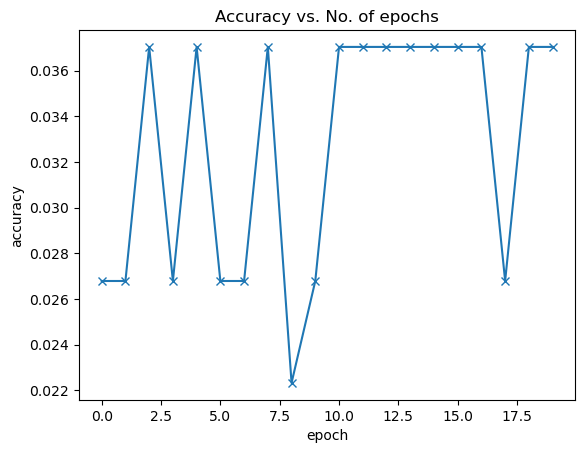

In [30]:
plot_accuracies(history)

In [31]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

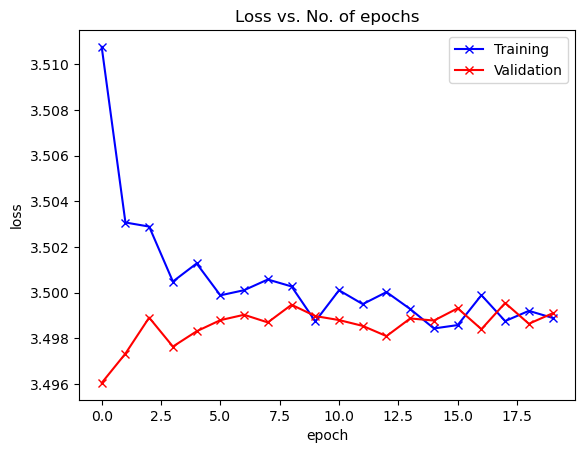

In [32]:
plot_losses(history)